# Example usage of the AWS ARISE-1.5 data set

Notebook shows how to access ARISE-1.5 CESM2-WACCM data from the AWS web store. 

Code below:
1. reads in near-surface air temperature data for ARISE-SAI-1.5 and SSP2-4.5, for 5 members each
2. processes into global and time-means
3. Make two simple plots - timeseries of global means and a spatial map of the temperature anomaly from the target state.

Data is here:
https://aws.amazon.com/marketplace/pp/prodview-7r3ocbnp5exq2#overview
https://registry.opendata.aws/ncar-cesm2-arise/

We use the s3fs and fsspec packages to mount the cloud repo. 

Note as of Sunday 9th February 2025: the approach here is limited by needing to hard code file paths to the data. In theory, intake-esm should help with this, using the catalog here (https://github.com/NCAR/CESM2-ARISE/tree/main). However, I couldn't get this to work. Pull requests to improve this are welcome! 

In [1]:
## packages for cloud data intake: 
import s3fs
import fsspec

## packages for analysis
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## test reading in a file to a dataset:
loc = 'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001.cam.h0.TREFHT.203501-206912.nc'

s3_path = "s3://" + loc

# Open the dataset directly from the S3 URL using xarray
with fsspec.open(s3_path, mode='rb', anon=True) as file:
    ds = xr.open_dataset(file, engine="h5netcdf")
ds['TREFHT']

/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


<xarray.DataArray 'TREFHT' (time: 420, lat: 192, lon: 288)> Size: 93MB
[23224320 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 3kB 2035-02-01 00:00:00 ... 2070-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [3]:
## read in multiple members to a single xarray dataset

def get_trefht_data(scenario='ARISE'):
    ds_list = []
    members = ['001', '002', '003', '004', '005']

    for member in members:

        locs = {'ARISE':'ncar-cesm2-arise/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{m}.cam.h0.TREFHT.203501-206912.nc'.format(m=member),
                'SSP245_1':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.201501-206412.nc'.format(m=member),
                'SSP245_2':'ncar-cesm2-arise/CESM2-WACCM-SSP245/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}/atm/proc/tseries/month_1/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.{m}.cam.h0.TREFHT.206501-210012.nc'.format(m=member)}
        loc = locs[scenario]
        s3_path = "s3://" + loc
        # Open the dataset directly from the S3 URL using xarray
        with fsspec.open(s3_path, mode='rb', anon=True) as file:
            ds = xr.open_dataset(file, engine="h5netcdf")
            ds_list.append(ds.load()) 
            # note that this takes a decent chunk of memory as we dont do anything clever with dask here            
    ds = xr.concat(ds_list, dim='member_id').assign_coords({'member_id':members})       
    ds = ds['TREFHT'].to_dataset(name='TREFHT') ## drop extra variables
    return ds

In [4]:
## get data for the geoengineering and the background (ssp245) scenario. 
## ssp245 is split into two files, as this run is longer
## cell takes a minute or so to run

ds_arise = get_trefht_data('ARISE')
ds_ssp245_early = get_trefht_data('SSP245_1')
ds_ssp245_late = get_trefht_data('SSP245_2')

## concatenate the two ssp245 datasets into one, along the time dimension
ds_ssp245 = xr.concat([ds_ssp245_early, ds_ssp245_late], dim='time')


## As an example, lets show global mean timeseries and time-mean maps

In [5]:
## first resample data to yearly resolution 
## we need to use a month weighting function here:

def weighted_annual_resample(ds):
    """
    weight by days in each month
    adapted from NCAR docs 
    https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    numerator = (ds * wgts).resample(time="YS").sum(dim="time")
    denominator = wgts.resample(time="YS").sum(dim="time")

    return numerator/denominator

ds_arise = weighted_annual_resample(ds_arise)
ds_ssp245 = weighted_annual_resample(ds_ssp245)

# also drop the final year from both because it is incomplete:
ds_arise = ds_arise.where(ds_arise.time.dt.year<2070, drop=True)
ds_ssp245 = ds_ssp245.where(ds_ssp245.time.dt.year<2100, drop=True)

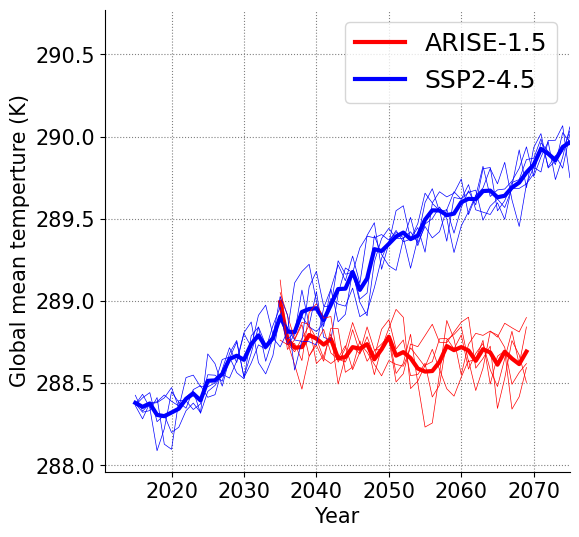

In [6]:
## plot global spatial mean timeseries:

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

var = 'TREFHT'
weights = np.cos(np.deg2rad(ds_arise['lat']))
ds_arise_global_mean =  ds_arise.weighted(weights).mean(dim='lat').mean('lon')
weights = np.cos(np.deg2rad(ds_ssp245['lat']))
ds_ssp245_global_mean =  ds_ssp245.weighted(weights).mean(dim='lat').mean('lon')

## and plot a timeseries figure
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(ds_arise_global_mean.time.dt.year.values, 
        ds_arise_global_mean.mean('member_id')[var].values,
            color = 'red', label='ARISE-1.5', lw=3)
ax.plot(ds_ssp245_global_mean.time.dt.year.values, 
        ds_ssp245_global_mean.mean('member_id')[var].values,
                color='blue', label='SSP2-4.5', lw=3)

for member in ['001', '002', '003', '004', '005']:
    ax.plot(ds_arise_global_mean.time.dt.year.values, 
            ds_arise_global_mean.sel(member_id=member)[var].values,
            color = 'red', lw=0.5)
    ax.plot(ds_ssp245_global_mean.time.dt.year.values, 
            ds_ssp245_global_mean.sel(member_id=member)[var].values,
                color='blue', lw=0.5)
ax.legend(fontsize='large')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(None, 2075)
ax.set_ylabel('Global mean temperture (K)')
ax.set_xlabel('Year')
ax.grid(ls='dotted', color='gray')
plt.savefig('Figures/ARISE_AWS_timeseries_example.jpg')

### now also plot temperature differences between ARISE and the target state, as a world map

In [7]:
## define some functions to assign statistical significance
from scipy.stats import t

def welchs_ttest_array(mean1, std1, n1, mean2, std2, n2):

    mean1, std1, n1 = np.array(mean1), np.array(std1), np.array(n1)
    mean2, std2, n2 = np.array(mean2), np.array(std2), np.array(n2)
    
    numerator = mean1 - mean2
    denominator = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    t_stat = numerator / denominator

    v1 = (std1**2 / n1)
    v2 = (std2**2 / n2)
    df = ((v1 + v2)**2) / ((v1**2 / (n1 - 1)) + (v2**2 / (n2 - 1)))

    return t_stat, df

def calculate_pvalue_array(t_stat, df):
    # Calculate two-sided p-values
    p_values = 2 * t.sf(np.abs(t_stat), df)
    return p_values

# we follow Wilks 2016 to define false discovery rate for stippling
# https://journals.ametsoc.org/view/journals/bams/97/12/bams-d-15-00267.1.xml
def fdr_threshold(pvalues, alpha=0.05):
    """Calculate the FDR threshold following Wilks (2016)"""
    pvals_sorted = np.sort(np.asarray(pvalues).flatten())
    N = len(pvals_sorted)
    return np.max(np.where(pvals_sorted <= (np.arange(1, N+1) / N * alpha), pvals_sorted, 0))

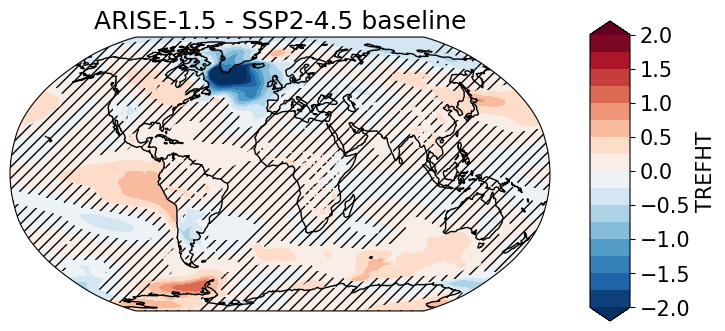

In [8]:
# import mapping tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# options
alpha = 0.05
clevs= np.arange(-2,2.1,0.25)
cols = 'RdBu_r'
var = 'TREFHT'

## get data and p_value threshold
ds_1 = ds_ssp245.sel(time=slice('2020', '2039')) # baseline period for ARISE CESM 
ds_2 = ds_arise.sel(time=slice('2050', '2069')) # final 20 years for assessment

t_stat, df = welchs_ttest_array(mean1=ds_1.mean(['time', 'member_id'])[var].values, 
                                std1=ds_1.std(['time', 'member_id'])[var].values,
                                n1=np.full_like(ds_1.std(['time', 'member_id'])[var].values, 100),
                                mean2=ds_2.mean(['time', 'member_id'])[var].values, 
                                std2=ds_2.std(['time', 'member_id'])[var].values,
                                n2=np.full_like(ds_2.std(['time', 'member_id'])[var].values, 100))
d = (ds_2.mean(['time', 'member_id']) - ds_1.mean(['time', 'member_id']))[var]

p_values = calculate_pvalue_array(t_stat, df)
p_values_xr = ds_1.mean(['time', 'member_id']).copy()
p_values_xr[var].values = p_values
p_thresh_fdr = fdr_threshold(p_values, alpha)
    
### plot
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(8,6))

data,lons=add_cyclic_point(d,coord=d['lon'])

cs=ax.contourf(lons, d['lat'], data, levels=clevs,
               transform = ccrs.PlateCarree(),
               cmap=cols,
               extend='both')

sig_mask = xr.where(p_values_xr[var]<p_thresh_fdr, 1, 0)
sig_mask_,lons=add_cyclic_point(sig_mask, coord=sig_mask['lon'])
cs_hatch = ax.contourf(lons,sig_mask['lat'],sig_mask_,
               transform = ccrs.PlateCarree(),
               levels=[0, 0.2, 1.2], colors='none',
               hatches=['///',None, None],
               extend='neither', zorder=1000)

ax.coastlines()
ax.set_title('ARISE-1.5 - SSP2-4.5 baseline')

### Add a colorbar
plt.subplots_adjust(right=0.8, hspace=0.4)
cax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = plt.colorbar(cs, cax=cax, orientation='vertical', label='TREFHT')

plt.savefig('Figures/ARISE_AWS_map_example.jpg', dpi=250)


## plot shows the difference between temperature under ARISE-SAI-1.5K over the period 2050-2069
## in CESM2, and the baseline temperature (2020-2039). Insignificant changes (at a 5% false-dicovery rate 
## threshold) are hatched. 